## Step 1: Load Required Libraries

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns  # For advanced visualization
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.preprocessing import StandardScaler, LabelEncoder  # For feature scaling and encoding categorical features
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc  # Model evaluation metrics
import os  # For checking file path existence
import warnings # For ignoring warnings
warnings.filterwarnings('ignore')


## Step 2: Load Dataset

In [2]:
file_path = 'Heart Prediction Quantum Dataset.csv'  # Define the path to the CSV file
if os.path.exists(file_path):  # Check if the file exists
    df = pd.read_csv(file_path)  # Load CSV into DataFrame
else:
    raise FileNotFoundError(f"Dataset not found at {file_path}")  # Raise error if file is missing


## Step 3: Data Exploration

In [3]:
print("Dataset Shape:", df.shape)  # Print number of rows and columns
print("\nFirst 5 Rows:")
print(df.head())  # Display first 5 records
print("\nSummary Statistics:")
print(df.describe())  # Show summary stats of numeric columns
print("\nMissing Values:")
print(df.isnull().sum())  # Count missing values in each column
print(df.columns)  # Print all column names
df.rename(columns=lambda x: x.strip(), inplace=True)  # Remove extra spaces from column names
print(df.columns)  # Check column names again after stripping spaces


Dataset Shape: (500, 7)

First 5 Rows:
   Age  Gender  BloodPressure  Cholesterol  HeartRate  QuantumPatternFeature  \
0   68       1            105          191        107               8.362241   
1   58       0             97          249         89               9.249002   
2   44       0             93          190         82               7.942542   
3   72       1             93          183        101               6.495155   
4   37       0            145          166        103               7.653900   

   HeartDisease  
0             1  
1             0  
2             1  
3             1  
4             1  

Summary Statistics:
              Age      Gender  BloodPressure  Cholesterol   HeartRate  \
count  500.000000  500.000000     500.000000    500.00000  500.000000   
mean    54.864000    0.468000     132.874000    221.50000   88.766000   
std     14.315004    0.499475      26.418516     43.86363   17.417289   
min     30.000000    0.000000      90.000000    150.00000  

## Step 4: EDA (Exploratory Data Analysis)

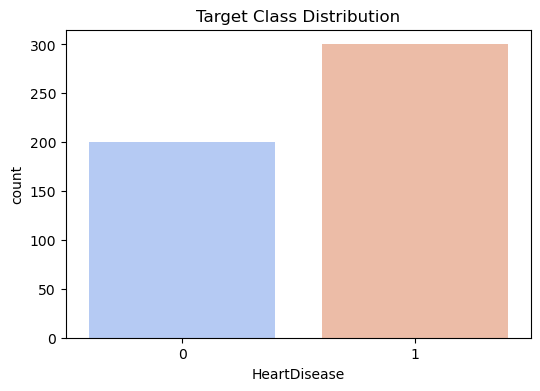

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='HeartDisease', data=df, palette='coolwarm')  # Plot count of classes in target variable
plt.title('Target Class Distribution')
plt.show()


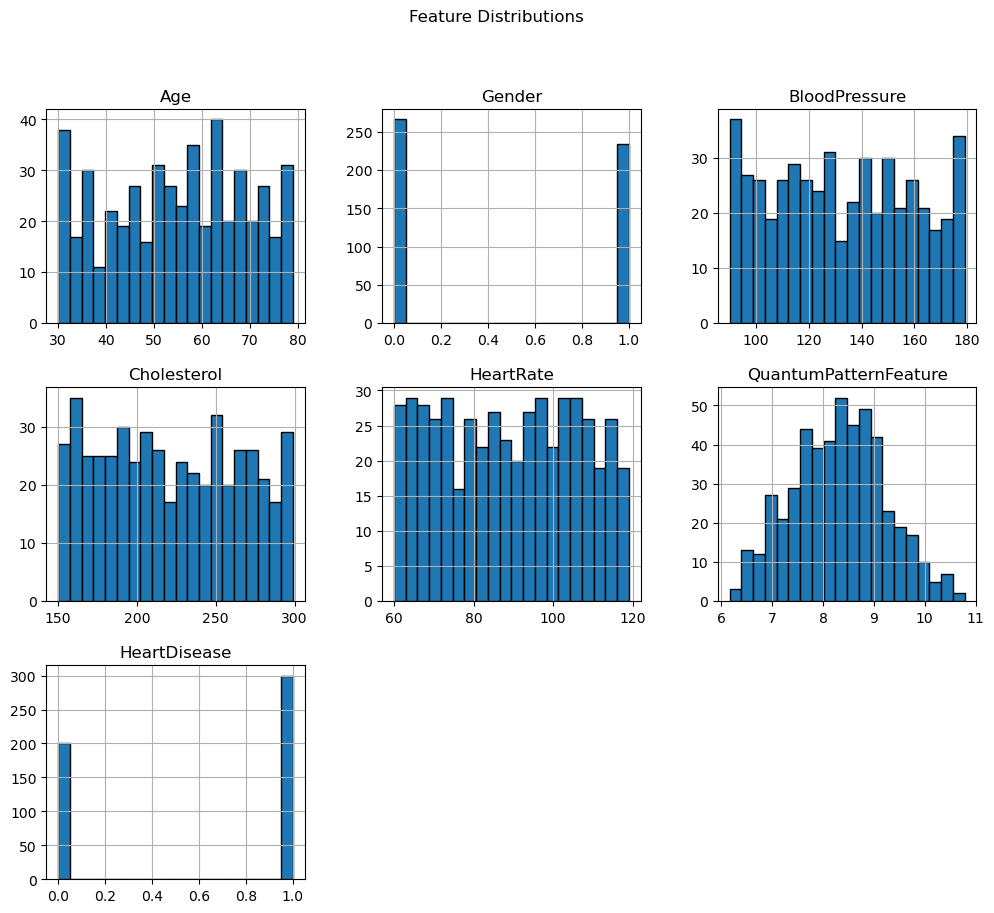

In [5]:
df.hist(figsize=(12,10), bins=20, edgecolor='black')  # Plot histograms for all numeric columns
plt.suptitle('Feature Distributions')
plt.show()


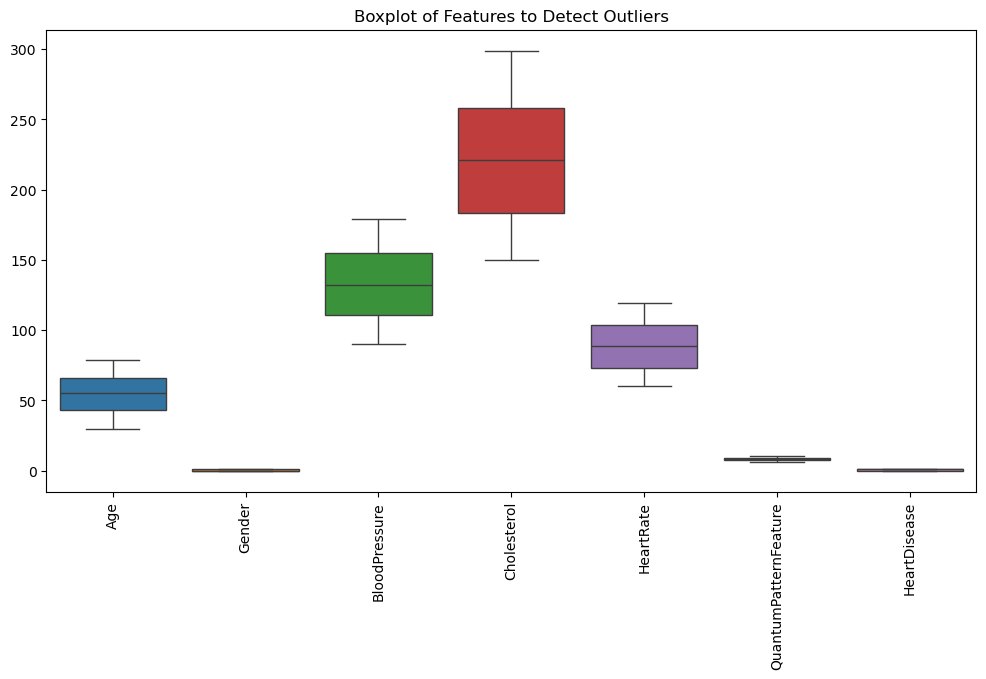

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df)  # Plot boxplots to identify outliers
plt.xticks(rotation=90)
plt.title('Boxplot of Features to Detect Outliers')
plt.show()


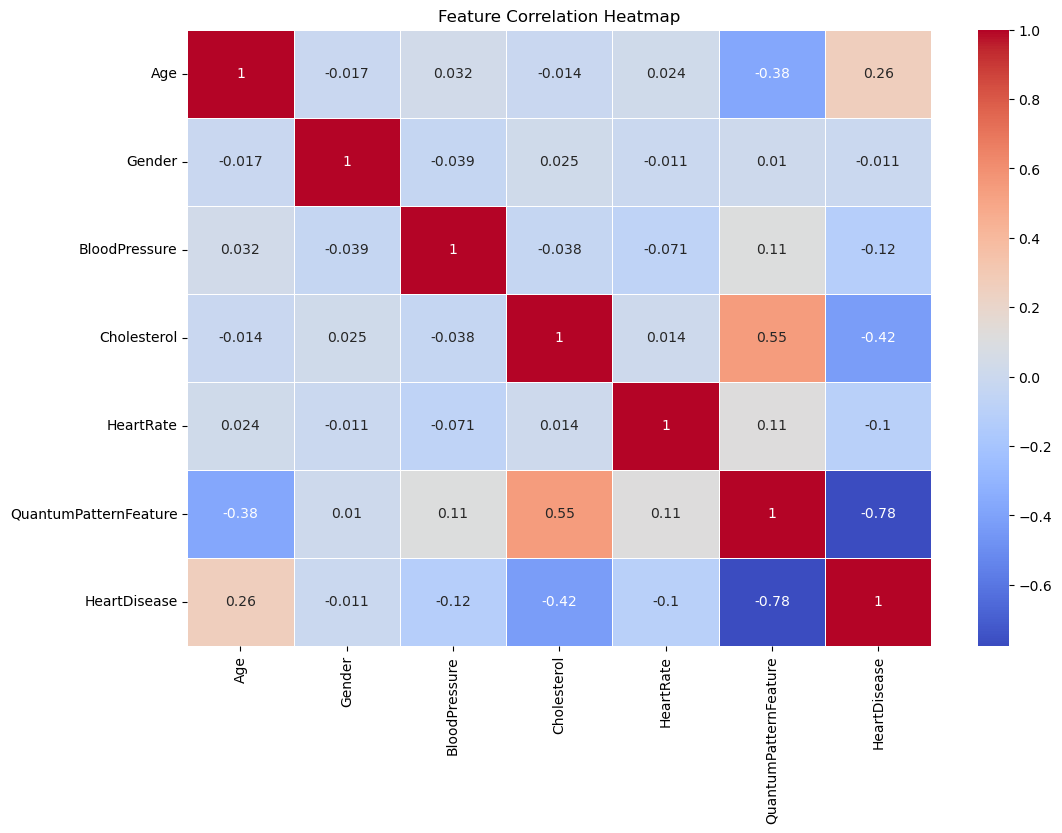

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)  # Correlation matrix
plt.title('Feature Correlation Heatmap')
plt.show()


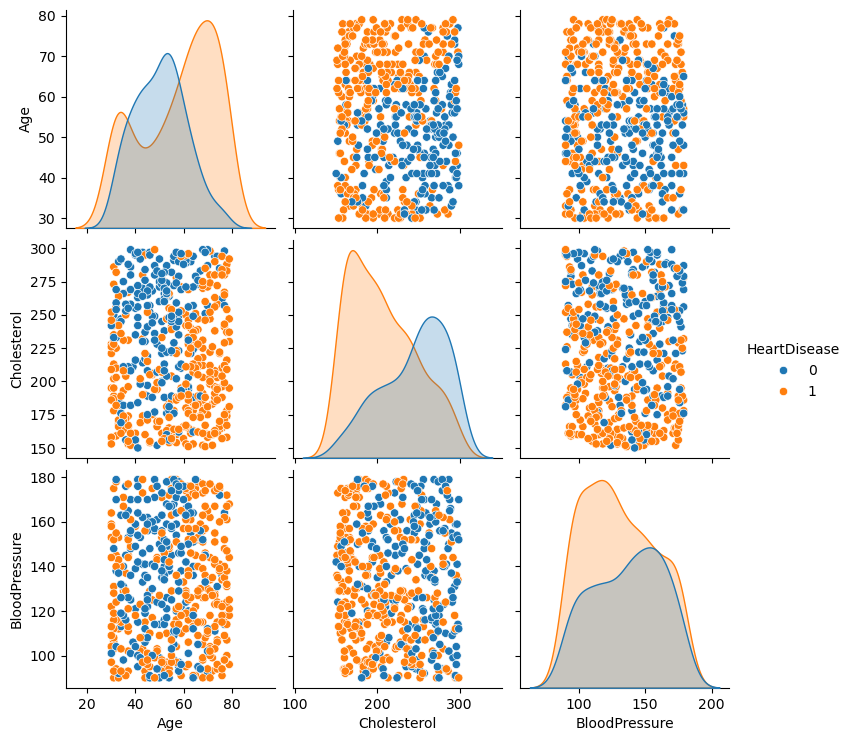

In [8]:
important_features = ['Age', 'Cholesterol', 'BloodPressure', 'HeartDisease']
sns.pairplot(df[important_features], hue='HeartDisease', diag_kind='kde')  # Pairwise relationships
plt.show()


## Step 5: Feature Engineering

In [9]:
df.dropna(inplace=True)  # Remove any rows with missing values


In [10]:
Q1 = df.quantile(0.25)  # First quartile
Q3 = df.quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range
lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]  # Remove rows with any outlier value


In [11]:
label_encoders = {}  # Dictionary to store label encoders
for column in df.select_dtypes(include=['object']).columns:  # Loop through object-type columns
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  # Encode each categorical feature
    label_encoders[column] = le  # Save the encoder


In [12]:
scaler = StandardScaler()  # Initialize standard scaler
df_scaled = pd.DataFrame(
    scaler.fit_transform(df.drop(columns=['HeartDisease'])),  # Scale features
    columns=df.drop(columns=['HeartDisease']).columns  # Retain column names
)
df_scaled['HeartDisease'] = df['HeartDisease'].values  # Add target column back


In [13]:
X = df_scaled.drop(columns=['HeartDisease'])  # Feature matrix
y = df_scaled['HeartDisease']  # Target vector


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24, stratify=y  # Split with stratification on target
)


## Step 6: Model Selection & Training

In [15]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}


In [16]:
for name, model in models.items():  # Loop through models
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    print(f"\n{name} Performance:")  # Print model name
    print(classification_report(y_test, y_pred))  # Print precision, recall, F1-score
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))  # Print confusion matrix



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.92      0.92      0.92        60

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Confusion Matrix:
[[35  5]
 [ 5 55]]

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        40
           1       0.93      0.92      0.92        60

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Confusion Matrix:
[[36  4]
 [ 5 55]]


## Step 7: Hyperparameter Tuning for Random Forest

In [17]:
param_grid = {  # Define parameter grid
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')  # Grid search with 5-fold CV
grid_search.fit(X_train, y_train)  # Fit model on training data
print("Best Parameters:", grid_search.best_params_)  # Show best hyperparameters


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


## Step 8: Final Model Evaluation

In [18]:
best_model = grid_search.best_estimator_  # Retrieve best model from grid search
y_pred = best_model.predict(X_test)  # Predict on test set
print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred))  # Show performance report



Final Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        40
           1       0.92      0.90      0.91        60

    accuracy                           0.89       100
   macro avg       0.88      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



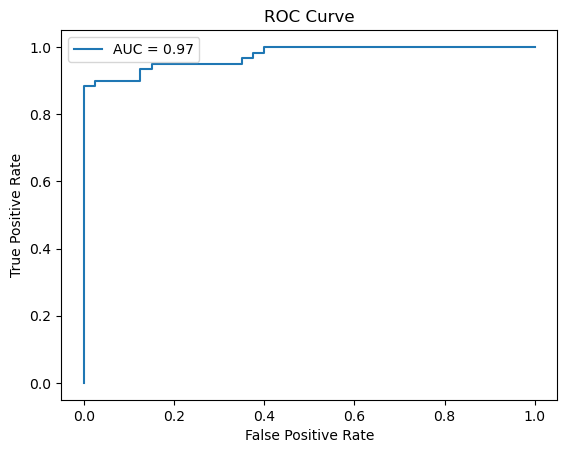

In [19]:
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])  # Compute ROC curve values
roc_auc = auc(fpr, tpr)  # Compute AUC
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')  # Plot ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
